# Import necessary libraries

In [31]:
import numpy as np
import pandas as pd
import tensorflow as tf
from itertools import chain
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer 

# Setting a seed for random stuff
seed = 54321

# Read the data 

Here the dataset will be a spam classification dataset. The dataset is available at

In [4]:
inputs = []
targets = []
with open("SMSSpamCollection", "r") as f:
    for row in f:
        inputs += [row.split()[1:]]
        targets += row.split()[:1]


inputs = pd.Series(inputs)
targets = pd.Series(targets).map({'spam':1, 'ham':0})

n_samples = 5
for inp, tgt in zip(inputs[:5], targets[:5]):
    print(inp)
    print(tgt)
    print("\n")

['Go', 'until', 'jurong', 'point,', 'crazy..', 'Available', 'only', 'in', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet...', 'Cine', 'there', 'got', 'amore', 'wat...']
0


['Ok', 'lar...', 'Joking', 'wif', 'u', 'oni...']
0


['Free', 'entry', 'in', '2', 'a', 'wkly', 'comp', 'to', 'win', 'FA', 'Cup', 'final', 'tkts', '21st', 'May', '2005.', 'Text', 'FA', 'to', '87121', 'to', 'receive', 'entry', 'question(std', 'txt', "rate)T&C's", 'apply', "08452810075over18's"]
1


['U', 'dun', 'say', 'so', 'early', 'hor...', 'U', 'c', 'already', 'then', 'say...']
0


['Nah', 'I', "don't", 'think', 'he', 'goes', 'to', 'usf,', 'he', 'lives', 'around', 'here', 'though']
0




# Splitting training and test data

In [7]:
# Shuffle the data
df = pd.DataFrame({'text': inputs, 'label': targets}).sample(frac=1.0, random_state=seed)

n = 250 # Number of samples for each label to generate the test set 

# Positive and negative indices of the original dataframe randomly sampled
pos_inds = df[(df==1)].sample(n=n, random_state=seed).index
neg_inds = df[(df==0)].sample(n=n, random_state=seed).index

# Get the data with indices
pos_test_samples = df.loc[pos_inds]
neg_test_samples = df.loc[neg_inds]

# Create the test dataset
test_samples = pd.concat([pos_test_samples, neg_test_samples]).sample(frac=1.0, random_state=seed)

# Separate inputs and targets
test_inputs, test_labels = test_samples["text"], test_samples["label"]

# Training data
train_samples = df.loc[(~df.index.isin(pos_inds) | ~df.index.isin(neg_inds))]
train_inputs, train_labels = train_samples["text"], train_samples["label"]

print("Train dataset size: {}".format(train_inputs.shape))
print("Test dataset size: {}".format(test_inputs.shape))

# Get the most common 1000 words
n_vocab = 1000
cnt = Counter(chain(*train_inputs.to_list()))
words, _ = zip(*cnt.most_common(n_vocab))


Train dataset size: (5324,)
Test dataset size: (500,)


# Print class imbalance in training data

In [138]:
print((1-(train_labels.value_counts()/train_labels.shape[0])).to_dict())

{0: 0.13336248360297331, 1: 0.8666375163970267}


# Creating n-grams with sentences

Here we do a few things.
* Create n-grams E.g. `"abc de f"` will be converted to `["a", "b", "c", ..., "ab", "bc", "c ", " d", ..., "abc", "bc ", "c d", ...]`, create a bag-of-words vector with the found n-grams
* Pad the sentences to a fixed length (and truncate longer ones)

In [12]:
# Define a count vectorizer that will create bag-of-words n-gram vectors
count_vectorizer = CountVectorizer(analyzer='char', ngram_range=(1,3))
# Fit the count vectorizer on the limited vocabulary to learn ngrams
count_vectorizer.fit(words)

def get_transformed_input(inputs, count_vectorizer, max_seq_length=15):
    """ Get the transformed input by adding empty spaces until the defined length is reached """
    transformed_inputs = []
    
    # For each input, tokenizer it and pad/truncate it
    for inp in inputs:
        if len(inp)<max_seq_length:
            inp = inp + ['']*(max_seq_length-len(inp))
        elif len(inp) > max_seq_length:
            inp = inp[:max_seq_length]
        
        # Get the output transformed by the count vectorizer
        out = count_vectorizer.transform(inp)
        transformed_inputs.append(out.toarray())
    
    transformed_inputs = np.stack(transformed_inputs, axis=0)
    
    return transformed_inputs

# Get preprocessed train data
train_transformed_input = get_transformed_input(train_inputs, count_vectorizer)
print("Transformed train set shape: {}".format(train_transformed_input.shape))
# Get preprocessed test data
test_transformed_input = get_transformed_input(test_inputs, count_vectorizer)
print("Transformed test set shape: {}".format(test_transformed_input.shape))

# Get n-grams learnt
feature_names = count_vectorizer.get_feature_names()
print("# of n-grams learnt: {}".format(len(feature_names)))
n_gram_count = len(feature_names)

Transformed train set shape: (5324, 15, 1583)
Transformed test set shape: (500, 15, 1583)
# of n-grams learnt: 1583


# Understanding core concepts of angular LSH

## Simplified angular LSH

In [19]:
bins = 32

b = np.random.normal(size=(n_gram_count, bins//2))

ngram_out = count_vectorizer.transform(["now", "Now", "now!", "today", "jungle"]).toarray()
print("ngram_out.shape = {}".format(ngram_out.shape))

x = np.dot(ngram_out, b)
print("x.shape = {}".format(x.shape))

outs = np.argmax(np.concatenate([x, -x], axis=-1), axis=-1)
print("Hash bins for the words are: {}".format(outs))

ngram_out.shape = (5, 1583)
x.shape = (5, 16)
Hash bins for the words are: [ 0  0  8  1 21]


## Increasing reliability: Extending angular LSH to multiple hashes

In [40]:
n_hashes = 8
bins = 32
      
b = np.random.normal(size=(n_hashes, o_arr.shape[-1], bins//2))

ngram_out = count_vectorizer.transform(words).toarray()
print("ngram_out.shape = {}".format(ngram_out.shape))

ngram_out = np.expand_dims(ngram_out, axis=0)
x = np.einsum('bij,hjk-> bhik', ngram_out, b)

print("x.shape = {}".format(x.shape))
# [batch dim, n_hashes, n_words]
outs = np.argmax(np.concatenate([x, -x], axis=-1), axis=-1).transpose([0, 2, 1])
print("outs.shape = {}".format(outs.shape))    

ngram_out.shape = (1000, 1583)
x.shape = (1, 8, 1000, 16)
outs.shape = (1, 1000, 8)


## Normalize to unit length

In [41]:
outs = outs[0, :, :]
outs = outs / np.sqrt((outs**2).sum(axis=-1, keepdims=True))

## Viola: Hash based word vectors

In [42]:
outs

array([[0.27874926, 0.1286535 , 0.1286535 , ..., 0.30019151, 0.38596051,
        0.57894077],
       [0.0630497 , 0.46236449, 0.25219881, ..., 0.63049703, 0.23118224,
        0.23118224],
       [0.13105561, 0.63343544, 0.54606504, ..., 0.32763902, 0.26211122,
        0.21842601],
       ...,
       [0.26006836, 0.54377929, 0.37828125, ..., 0.54377929, 0.2127832 ,
        0.23642578],
       [0.32762406, 0.32762406, 0.10238252, ..., 0.38905357, 0.10238252,
        0.22524154],
       [0.44149208, 0.38390615, 0.26873431, ..., 0.57585923, 0.23034369,
        0.19195308]])

# How do they perform?

## Visualizing vectors via T-SNE

In [36]:
outs_embedded = TSNE(
    n_components=2, init='random', metric='cosine'
).fit_transform(outs.astype('float32'))

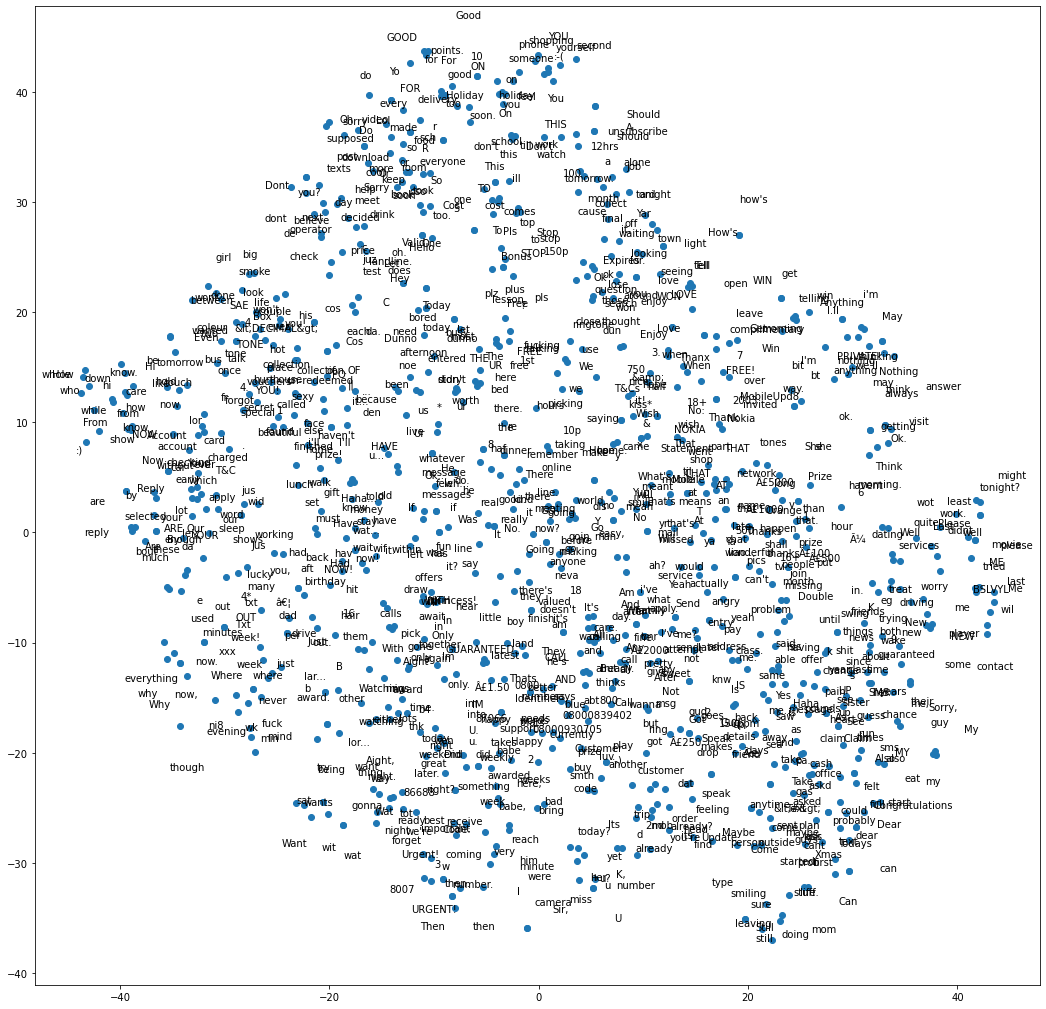

In [38]:
f, ax = plt.subplots(1, 1, figsize=(18,18))
ax.scatter(outs_embedded[:,0], outs_embedded[:,1])

for i, txt in enumerate(words):
    ax.annotate(txt, (outs_embedded[i,0]+np.random.randint(-4, 4), outs_embedded[i,1]+np.random.randint(-4, 4)))

## Print similar words

Some interesting examples 

```
Love ['LOVE', 'love', 'their', 'Well', 'well']
My ['my', 'MY', 'T&Cs', 'Â£1.50', 'price']
ARE ['Are', 'ARE', 're', 'remember', 'care']
Call ['Call', 'call', 'CALL', "I'll", "i'll"]
```

In [47]:
k = 5
sort_ids = np.argsort(-np.dot(outs, outs.T), axis=-1)[:, 1:k+1]
print(sort_ids.shape)

probe_ids = np.random.randint(1000, size=10)

for pid in probe_ids:
    
    print(words[pid], [words[sid] for sid in sort_ids[pid]])

(1000, 5)
player ['contact', 'play', 'thing', 'like', 'ard']
by ['by', 'today', 'Today', 'B', 'b']
ARE ['Are', 'ARE', 're', 'remember', 'care']
eat ['treat', 'believe', 'ready', 'came', 'name']
should ['should', 'cool', 'early', 'collection.', 'dun']
Call ['Call', 'call', 'CALL', "I'll", "i'll"]
8007 ['mail', "doesn't", 'from', 'From', 'await']
Well ['Well', 'love', 'Love', 'LOVE', 'Call']
outside ['won', 'WON', 'cash', 'up', 'UP']
first ['talk', 'money', '!!', 'WIN', 'Win']


# Let's use this in a model!

In [53]:
tf.keras.backend.clear_session()

class Hash2Vec(tf.keras.layers.Layer):
    
    def __init__(self, hash_bins, n_hashes):
        """ Initialize the random matrix """
        # A matrix of size [number of hashes, feature dim, number of bins]
        self.b = None
        self.hash_bins = hash_bins
        self.n_hashes = n_hashes
        
        super().__init__()
    
    def build(self, input_shape):
        # [b, seq, ngrams]
        self.b = self.add_weight(
            shape=(self.n_hashes, input_shape[-1], self.hash_bins//2),
            initializer='random_normal',
            trainable=False
        )

        
    def call(self, x):
        """ The actual computation of the hash vectors """
        # x - [batch size, sequence leng, feature dim]
        # out - [batch size, number of hashes, seqeuence length, number of bins]
        batch_hashed_x = tf.einsum('bij,hjk->bhik', x, self.b)

        # out - [batch size, n_hashes, sequence len]
        batch_closest_neighbor = tf.cast(tf.transpose(tf.argmax(batch_hashed_x, axis=-1), [0, 2, 1]), 'float32')
        # Normalize the vectors
        return tf.math.l2_normalize(batch_closest_neighbor, axis=-1)
    
    def get_config(self):
        """ TODO """
        pass

    
seq_length = 15
ngram_dim = len(count_vectorizer.get_feature_names())
n_hashes = 64
bins = 64

# Defining the random matrix
b = np.random.normal(size=(n_hashes, ngram_dim, bins//2))

# Defining the model

# Defining input layer
ngram_input = tf.keras.layers.Input(shape=(seq_length, ngram_dim))
# Define the hash2vec layer
hash2vec_out = Hash2Vec(bins, n_hashes, trainable=False)(ngram_input)
# Define a layer to flatten the time dimension and create a long vector containing outputs of all steps
summed_out = tf.keras.layers.Flatten()(hash2vec_out)
# Dense hidden layer
dense_out = tf.keras.layers.Dense(64, activation='relu')(summed_out)
# Final layer
dense_out = tf.keras.layers.Dense(1, activation='sigmoid')(dense_out)

# Define the final model and compile it
model = tf.keras.models.Model(inputs=ngram_input, outputs=dense_out)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 15, 1583)]        0         
_________________________________________________________________
hash2_vec (Hash2Vec)         (None, 15, 64)            3241984   
_________________________________________________________________
flatten (Flatten)            (None, 960)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                61504     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 3,303,553
Trainable params: 3,303,553
Non-trainable params: 0
_________________________________________________________________


# Training the model

In [54]:
model.fit(
    train_transformed_input, 
    train_labels, 
    class_weight=(1-(train_labels.value_counts()/train_labels.shape[0])).to_dict(),
    epochs=5, batch_size=128
)

Epoch 1/5
42/42 [==============================] - 6s 123ms/step - loss: 0.1219 - accuracy: 0.6416
Epoch 2/5
42/42 [==============================] - 5s 120ms/step - loss: 0.1064 - accuracy: 0.6801
Epoch 3/5
42/42 [==============================] - 5s 119ms/step - loss: 0.0969 - accuracy: 0.6927
Epoch 4/5
42/42 [==============================] - 5s 121ms/step - loss: 0.0890 - accuracy: 0.7487
Epoch 5/5
42/42 [==============================] - 5s 118ms/step - loss: 0.0860 - accuracy: 0.7900


# Evauate the model on test data

In [55]:
model.evaluate(test_transformed_input, test_labels)

16/16 [==============================] - 1s 41ms/step - loss: 0.3012 - accuracy: 0.8800


[0.3012472093105316, 0.8799999952316284]

# Comparing to trainable word vectors

In [143]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=1000,
    filters='',
    lower=False, oov_token='UNK'
)


train_sentences = [' '.join(msg) for msg in train_inputs]
print(len(train_sentences))
tokenizer.fit_on_texts(train_sentences)
train_sequences = tokenizer.texts_to_sequences(train_sentences)
pad_train_sequences = tf.keras.preprocessing.sequence.pad_sequences(
    train_sequences, maxlen=15, dtype='int32', padding='post',
    truncating='post', value=0.0
)
test_sentences = [' '.join(msg) for msg in test_inputs]
test_sequences = tokenizer.texts_to_sequences(test_sentences)
pad_test_sequences = tf.keras.preprocessing.sequence.pad_sequences(
    test_sequences, maxlen=15, dtype='int32', padding='post',
    truncating='post', value=0.0
)


4574


In [156]:
import tensorflow as tf
import numpy as np

tf.keras.backend.clear_session()

    
seq_length = 15
n_hashes = 64


ngram_input = tf.keras.layers.Input(shape=(seq_length,))
emb_out = tf.keras.layers.Embedding(1001, n_hashes//2)(ngram_input)
summed_out = tf.keras.layers.Flatten()(emb_out)
dense_out = tf.keras.layers.Dense(64, activation='relu')(summed_out)
dense_out = tf.keras.layers.Dense(1, activation='sigmoid')(dense_out)

model = tf.keras.models.Model(inputs=ngram_input, outputs=dense_out)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 15)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 32)            32032     
_________________________________________________________________
flatten (Flatten)            (None, 480)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                30784     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 62,881
Trainable params: 62,881
Non-trainable params: 0
_________________________________________________________________


In [157]:
model.fit(
    pad_train_sequences[:15], 
    train_labels.iloc[:15], 
    class_weight=(1-(train_labels.value_counts()/train_labels.shape[0])).to_dict(),
    epochs=5, 
    batch_size=128
)

model.evaluate(pad_test_sequences, test_labels)

Epoch 1/5
1/1 [==============================] - 0s 437ms/step - loss: 0.1594 - accuracy: 0.5333
Epoch 2/5
1/1 [==============================] - 0s 3ms/step - loss: 0.1545 - accuracy: 0.8667
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 0.1501 - accuracy: 0.8667
Epoch 4/5
1/1 [==============================] - 0s 3ms/step - loss: 0.1459 - accuracy: 0.9333
Epoch 5/5
63/63 [==============================] - 0s 1ms/step - loss: 0.6585 - accuracy: 0.7580


[0.6585277915000916, 0.7580000162124634]